# HVNM Startup Shear: Dual TST Overshoot with Strain Amplification

## Introduction

In startup shear at constant $\dot{\gamma}$, the HVNM exhibits **dual TST stress overshoot** from both matrix (E-network) and interphase (I-network) bond exchange reactions. The initial slope is amplified by nanoparticles: $G_{tot}^{NC} = G_P X(\phi) + G_E + G_D + G_{I,eff} X_I$. At steady state, both $\sigma_E \to 0$ and $\sigma_I \to 0$ because the natural states fully track the deformation via TST kinetics. Higher $\phi$ increases the overshoot magnitude due to amplified affine deformation and mechanochemical feedback through $V_{act}$.

> **Handbook:** See [HVNM Protocol Derivations](../../docs/source/models/hvnm/hvnm_protocols.rst) for ODE formulation and [Knowledge Extraction](../../docs/source/models/hvnm/hvnm_knowledge.rst) for extracting $V_{act}^{mat}$ and $V_{act}^{int}$ from overshoot analysis.

## Learning Objectives

- Simulate constant-rate startup from equilibrium with nanoparticle amplification
- Observe enhanced initial slope: $G_{tot} = G_P X + G_E + G_D + G_{I,eff} X_I$
- Compare dual TST mechanochemical feedback (E-network + I-network)
- Examine $\phi$-dependent overshoot magnitude and position

## Prerequisites
- **Notebook 01** — SAOS fundamentals
- **Notebook 02** — Relaxation dynamics

## Estimated Runtime
- ~2-3 min (17-component ODE integration)

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import HVNMLocal

jax, jnp = safe_import_jax()
verify_float64()
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

## 2. Theory

In startup shear at constant $\dot{\gamma}$, the stress initially grows linearly:

$$\sigma(t \to 0) \approx (G_P X + G_E + G_D + G_I^{\text{eff}} X_I) \dot{\gamma} t$$

where:
- $X = 1 + \phi \alpha_{\rm hyd}$ is the strain amplification (Guth-Gold)
- $X_I = 1 + \phi \alpha_I$ is the interfacial amplification (higher than bulk)
- $G_I^{\text{eff}} = \beta_I G_E$ is the effective interfacial stiffness

With dual TST kinetics:
- E-network BER: $k_{\text{BER}}^E \propto \cosh(V_{\text{act}} \sigma_{\text{VM}}^E / RT)$
- I-network BER: $k_{\text{BER}}^I \propto \cosh(V_{\text{act}} \sigma_{\text{VM}}^I / RT)$

Both create stress overshoots, with the interfacial contribution enhanced by higher TST sensitivity.

At steady state:
- $\sigma_E = 0$ (natural state fully tracks deformation)
- $\sigma_I = 0$ (interfacial natural state fully tracks deformation)
- $\sigma_P = G_P X \gamma$ (amplified elastic storage)
- $\sigma_D = (G_D / k_d^D) \dot{\gamma}$ (Newtonian viscous)

## 3. Model Setup

In [3]:
model = HVNMLocal(kinetics="stress")
model.parameters.set_value("G_P", 5000.0)
model.parameters.set_value("G_E", 3000.0)
model.parameters.set_value("G_D", 1000.0)
model.parameters.set_value("phi", 0.1)
model.parameters.set_value("beta_I", 3.0)
model.parameters.set_value("nu_0", 1e10)
model.parameters.set_value("E_a", 80e3)
model.parameters.set_value("V_act", 1e-4)
model.parameters.set_value("T", 350.0)
model.parameters.set_value("k_d_D", 10.0)

print("Model configured with nanoparticle fraction φ =", model.phi)
print(f"Strain amplification X_phi = {model.X_phi:.3f}")
print(f"Interfacial amplification X_I = {model.X_I:.3f}")
print(f"G_I_eff = {model.G_I_eff:.1f} Pa")

Model configured with nanoparticle fraction φ = 0.1
Strain amplification X_phi = 1.391
Interfacial amplification X_I = 1.478
G_I_eff = 2309.6 Pa


## 4. Single-Rate Startup Prediction

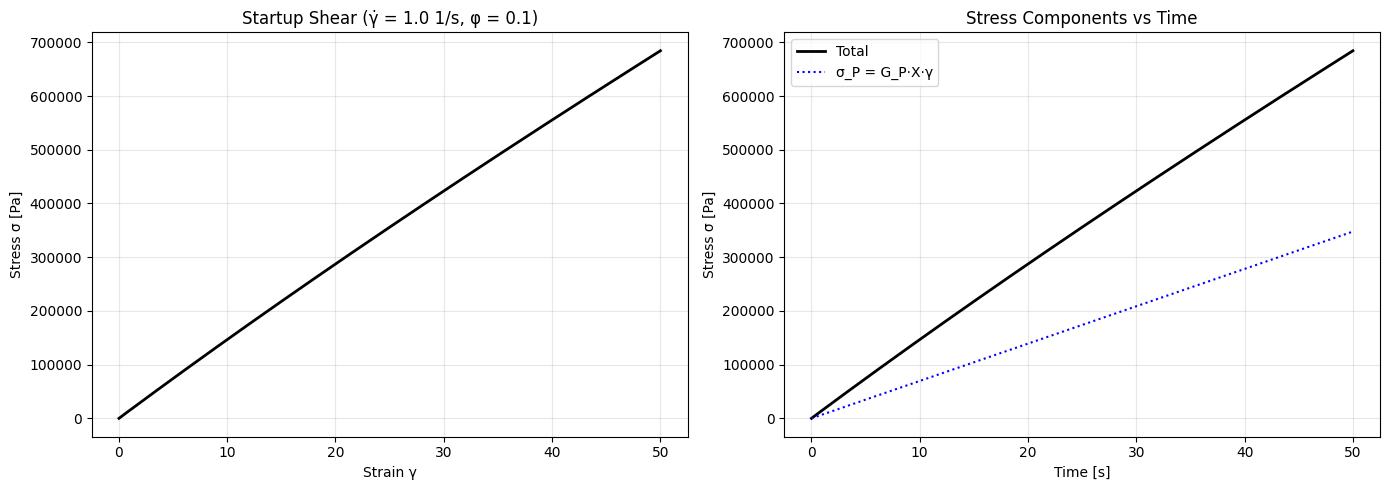

In [4]:
t = np.linspace(0.01, 50, 300)
gamma_dot = 1.0

stress = model.simulate_startup(t, gamma_dot=gamma_dot, return_full=False)
strain = gamma_dot * t

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(strain, stress, "k-", lw=2)
ax1.set_xlabel("Strain γ")
ax1.set_ylabel("Stress σ [Pa]")
ax1.set_title(f"Startup Shear (γ̇ = {gamma_dot} 1/s, φ = {model.phi})")
ax1.grid(True, alpha=0.3)

# Time domain
ax2.plot(t, stress, "k-", lw=2, label="Total")
ax2.plot(t, model.G_P * model.X_phi * strain, "b:", lw=1.5, label="σ_P = G_P·X·γ")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Stress σ [Pa]")
ax2.set_title("Stress Components vs Time")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Component Decomposition

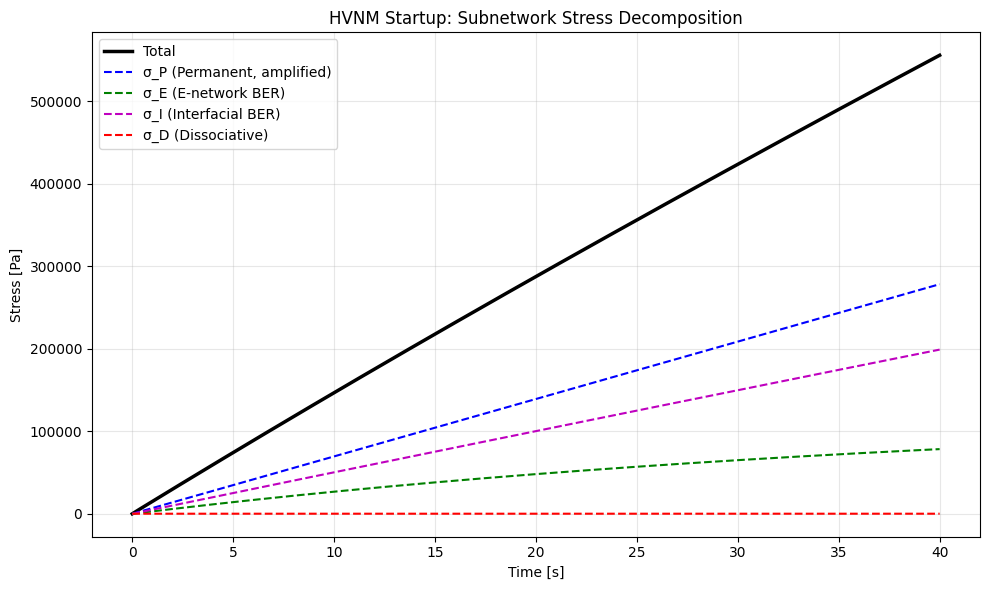


Key observations:
- σ_E and σ_I both relax to zero at steady state (dual vitrimer signature)
- σ_P grows linearly with amplified slope G_P*X*γ̇
- σ_D plateaus at viscous contribution (G_D/k_d^D)*γ̇


In [5]:
t = np.linspace(0.01, 40, 300)
result_full = model.simulate_startup(t, gamma_dot=gamma_dot, return_full=True)

# Compute stress components from internal state
strain_arr = result_full["strain"]
sigma_total = result_full["stress"]
sigma_P = model.G_P * model.X_phi * strain_arr  # Permanent (amplified, linear elastic)
sigma_E = model.G_E * (result_full["mu_E_xy"] - result_full["mu_E_nat_xy"])  # E-network
sigma_D = model.G_D * result_full["mu_D_xy"]  # D-network
G_I_eff = model.G_I_eff
sigma_I = G_I_eff * model.X_I * (result_full["mu_I_xy"] - result_full["mu_I_nat_xy"])

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t, sigma_total, "k-", lw=2.5, label="Total")
ax.plot(t, sigma_P, "b--", lw=1.5, label="σ_P (Permanent, amplified)")
ax.plot(t, sigma_E, "g--", lw=1.5, label="σ_E (E-network BER)")
ax.plot(t, sigma_I, "m--", lw=1.5, label="σ_I (Interfacial BER)")
ax.plot(t, sigma_D, "r--", lw=1.5, label="σ_D (Dissociative)")

ax.set_xlabel("Time [s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title("HVNM Startup: Subnetwork Stress Decomposition")
ax.legend(loc="best")
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print("\nKey observations:")
print(f"- σ_E and σ_I both relax to zero at steady state (dual vitrimer signature)")
print(f"- σ_P grows linearly with amplified slope G_P*X*γ̇")
print(f"- σ_D plateaus at viscous contribution (G_D/k_d^D)*γ̇")

## 6. φ Effect on Peak Stress

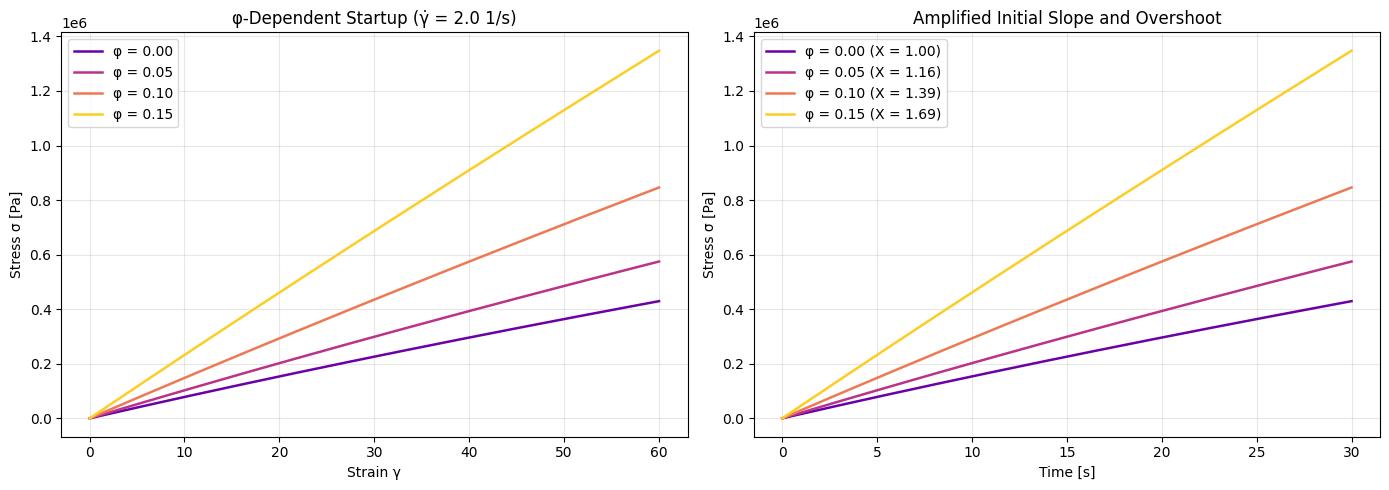


Amplification effect:
  φ = 0.00 → X(φ) = 1.000
  φ = 0.05 → X(φ) = 1.160
  φ = 0.10 → X(φ) = 1.391
  φ = 0.15 → X(φ) = 1.692


In [6]:
phi_values = [0.0, 0.05, 0.1, 0.15]
colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(phi_values)))

t = np.linspace(0.01, 30, 200)
gamma_dot = 2.0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for phi, color in zip(phi_values, colors):
    model_phi = HVNMLocal(kinetics="stress")
    model_phi.parameters.set_value("G_P", 5000.0)
    model_phi.parameters.set_value("G_E", 3000.0)
    model_phi.parameters.set_value("G_D", 1000.0)
    model_phi.parameters.set_value("phi", phi)
    model_phi.parameters.set_value("beta_I", 3.0)
    model_phi.parameters.set_value("nu_0", 1e10)
    model_phi.parameters.set_value("E_a", 80e3)
    model_phi.parameters.set_value("V_act", 1e-4)
    model_phi.parameters.set_value("T", 350.0)
    model_phi.parameters.set_value("k_d_D", 10.0)
    
    stress_arr = model_phi.simulate_startup(t, gamma_dot=gamma_dot, return_full=False)
    strain_arr = gamma_dot * t
    
    ax1.plot(strain_arr, stress_arr, "-", color=color, lw=1.8,
             label=f"φ = {phi:.2f}")
    ax2.plot(t, stress_arr, "-", color=color, lw=1.8,
             label=f"φ = {phi:.2f} (X = {model_phi.X_phi:.2f})")

ax1.set_xlabel("Strain γ")
ax1.set_ylabel("Stress σ [Pa]")
ax1.set_title(f"φ-Dependent Startup (γ̇ = {gamma_dot} 1/s)")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Stress σ [Pa]")
ax2.set_title("Amplified Initial Slope and Overshoot")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nAmplification effect:")
for phi in phi_values:
    X = 1 + phi * 2.5 + 14.1 * phi**2
    print(f"  φ = {phi:.2f} → X(φ) = {X:.3f}")

## 7. Internal State Evolution (E and I Networks)

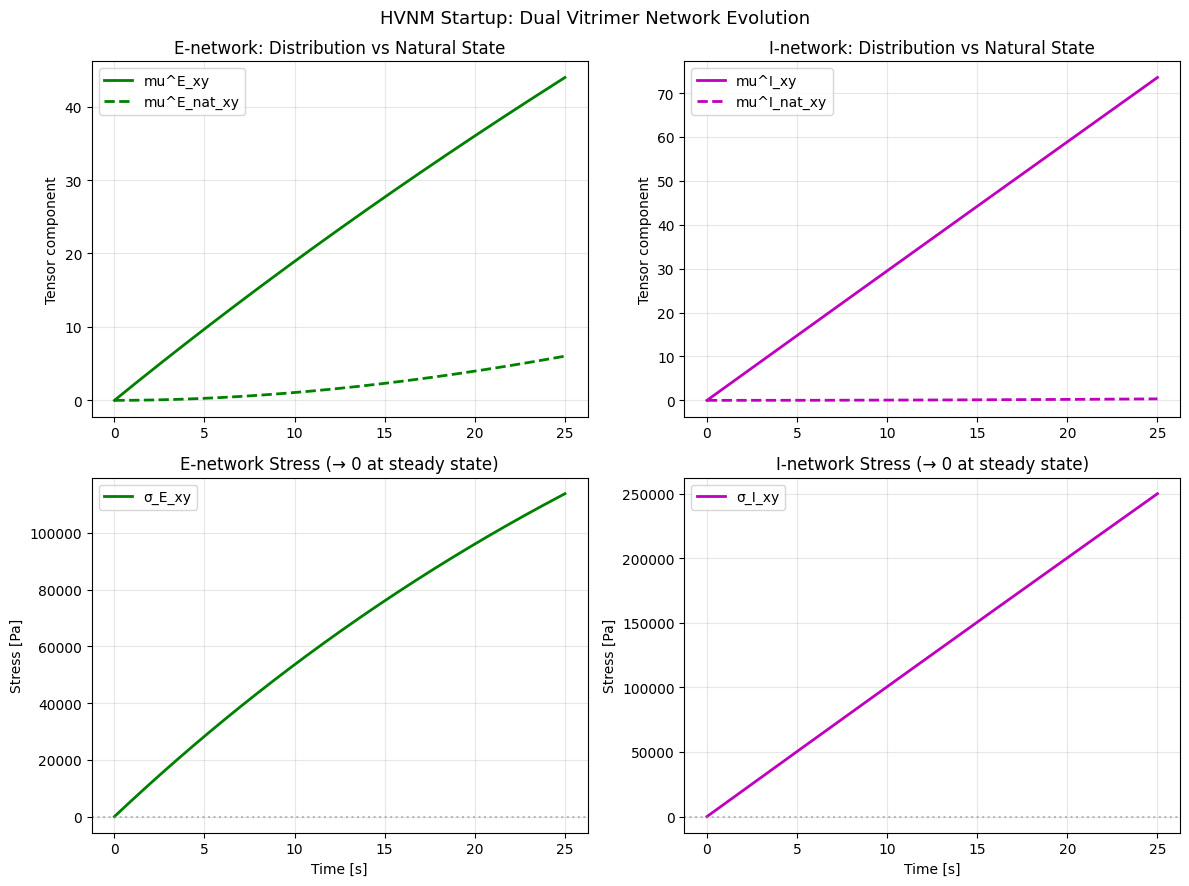

In [7]:
t = np.linspace(0.01, 25, 200)
result = model.simulate_startup(t, gamma_dot=2.0, return_full=True)

fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# E-network: mu_E vs mu_E_nat
axes[0, 0].plot(t, result["mu_E_xy"], "g-", lw=2, label="mu^E_xy")
axes[0, 0].plot(t, result["mu_E_nat_xy"], "g--", lw=2, label="mu^E_nat_xy")
axes[0, 0].set_ylabel("Tensor component")
axes[0, 0].set_title("E-network: Distribution vs Natural State")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# I-network: mu_I vs mu_I_nat
axes[0, 1].plot(t, result["mu_I_xy"], "m-", lw=2, label="mu^I_xy")
axes[0, 1].plot(t, result["mu_I_nat_xy"], "m--", lw=2, label="mu^I_nat_xy")
axes[0, 1].set_ylabel("Tensor component")
axes[0, 1].set_title("I-network: Distribution vs Natural State")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# E-network stress
sigma_E_xy = model.G_E * (result["mu_E_xy"] - result["mu_E_nat_xy"])
axes[1, 0].plot(t, sigma_E_xy, "g-", lw=2, label="σ_E_xy")
axes[1, 0].axhline(0, color="gray", ls=":", alpha=0.5)
axes[1, 0].set_xlabel("Time [s]")
axes[1, 0].set_ylabel("Stress [Pa]")
axes[1, 0].set_title("E-network Stress (→ 0 at steady state)")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# I-network stress
G_I_eff = model.G_I_eff
sigma_I_xy = G_I_eff * model.X_I * (result["mu_I_xy"] - result["mu_I_nat_xy"])
axes[1, 1].plot(t, sigma_I_xy, "m-", lw=2, label="σ_I_xy")
axes[1, 1].axhline(0, color="gray", ls=":", alpha=0.5)
axes[1, 1].set_xlabel("Time [s]")
axes[1, 1].set_ylabel("Stress [Pa]")
axes[1, 1].set_title("I-network Stress (→ 0 at steady state)")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle("HVNM Startup: Dual Vitrimer Network Evolution", fontsize=13)
plt.tight_layout()
display(fig)
plt.close(fig)

## Key Takeaways

1. **Amplified initial slope**: $G_{tot} = G_P X + G_E + G_D + G_{I,eff} X_I$ increases with $\phi$
2. **Dual TST overshoot**: Both E-network and I-network contribute to stress peak
3. **$\sigma_E \to 0$ and $\sigma_I \to 0$**: Dual vitrimer signature at steady state
4. **Higher $\phi$ → larger overshoot**: Nanoparticles amplify mechanochemical feedback
5. **$\sigma_P$ grows linearly**: Amplified permanent network stores elastic energy ($G_P X \gamma$)

## Further Reading

**Handbook Documentation:**
- [HVNM Protocol Derivations](../../docs/source/models/hvnm/hvnm_protocols.rst) — ODE formulation, TST kinetics
- [HVNM Knowledge Extraction](../../docs/source/models/hvnm/hvnm_knowledge.rst) — Extracting $V_{act}^{mat}$ and $V_{act}^{int}$ from overshoot

**Key References:**
1. Karim, M.R., Vernerey, F. & Sain, T. (2025). *Macromolecules*, 58(10), 4899-4912.

## Next Notebooks

- **Notebook 04**: Creep — Three retardation modes, NP-reduced compliance
- **Notebook 05**: Flow curves — $\phi$-independent steady state
- **Notebook 06**: LAOS — Payne onset at $\gamma_c / X_I$